# Credit Card Fraud Detection Analysis

This notebook implements credit card fraud detection using anomaly detection techniques.

## Overview
- We'll use two unsupervised learning algorithms: Isolation Forest and Local Outlier Factor (LOF)
- These techniques are effective for detecting outliers/anomalies in the data
- Credit card fraud detection is a classic application of anomaly detection

In [115]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import precision_recall_curve, auc, roc_curve, make_scorer
import warnings
warnings.filterwarnings('ignore')

# Import your existing utility module
import credit_card_fraud_utils as ccf





%matplotlib inline
plt.style.use('seaborn-v0_8') # Updated style name for compatibility

<Figure size 800x550 with 0 Axes>

## 1. Setup and Configuration

In [116]:
# Initialize configuration
config = ccf.Config()

# You can modify config parameters here if needed
# config.IF_CONTAMINATION = 0.02
# config.LOF_N_NEIGHBORS = 25

# Display default configuration
print("Configuration Parameters:")
for attr, value in config.__dict__.items():
    print(f"{attr} = {value}")

Configuration Parameters:


## 2. Data Loading and Understanding

In [117]:
# Load the dataset
df = ccf.load_data(config)

# Display basic information
print(f"Dataset Shape: {df.shape}")
print(f"Number of Transactions: {df.shape[0]}")
print(f"Number of Features: {df.shape[1]}")

# Display the first few rows
df.head()

Dataset Shape: (284807, 31)
Number of Transactions: 284807
Number of Features: 31


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [118]:
# Get a summary of the dataset
summary = ccf.get_data_summary(df)

print(f"Missing Values: {summary['missing_values']}")
print(f"Normal Transactions: {summary['normal_count']} ({100 - summary['fraud_percentage']:.2f}%)")
print(f"Fraudulent Transactions: {summary['fraud_count']} ({summary['fraud_percentage']:.2f}%)")

# Based on the actual fraud percentage, we might want to update the contamination parameter
print(f"\nRecommended contamination value: {summary['fraud_percentage'] / 100:.6f}")
config.IF_CONTAMINATION = summary['fraud_percentage'] / 100
config.LOF_CONTAMINATION = summary['fraud_percentage'] / 100

Missing Values: 0
Normal Transactions: 284315 (99.83%)
Fraudulent Transactions: 492 (0.17%)

Recommended contamination value: 0.001727


## 3. Exploratory Data Analysis

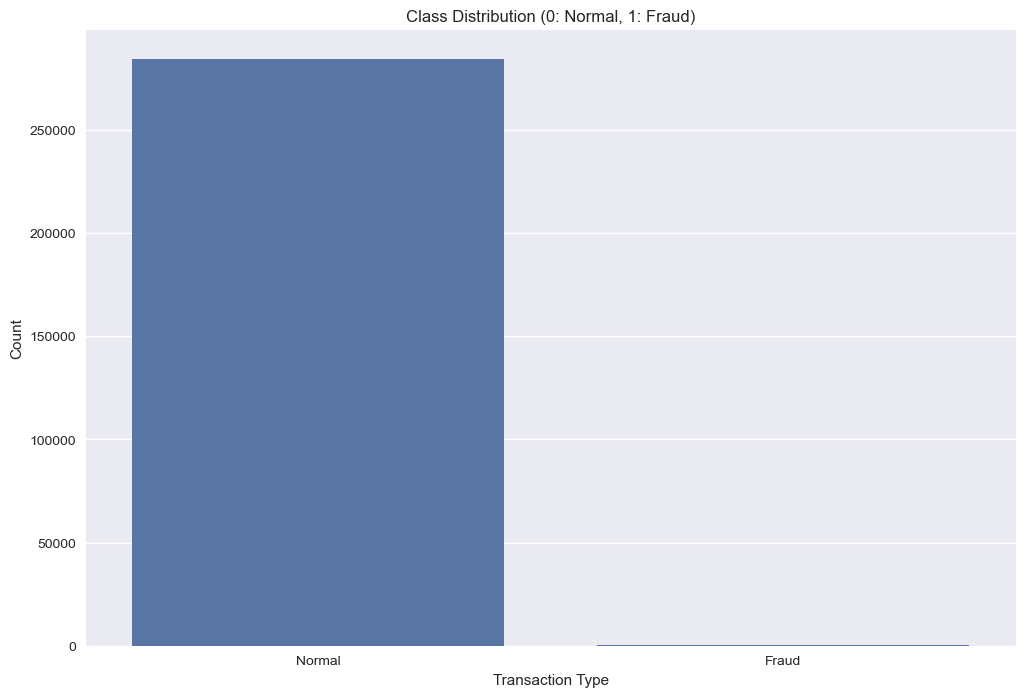

In [119]:
# Plot class distribution
plt_class = ccf.plot_class_distribution(df, config)
plt_class.show()

<Figure size 1200x800 with 0 Axes>

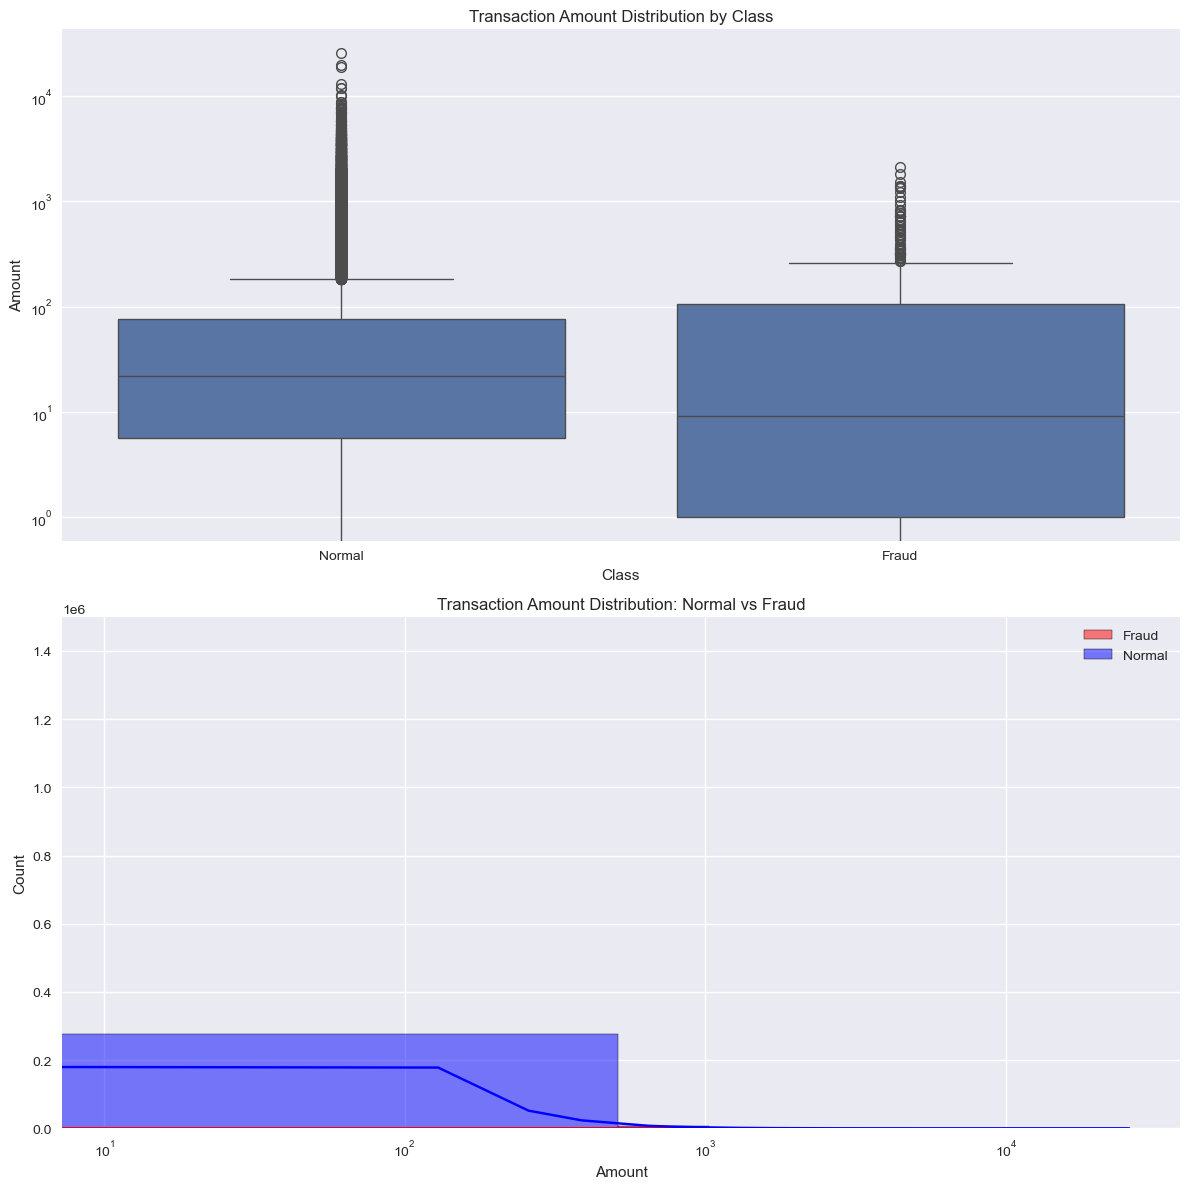

In [120]:
# Plot transaction amount distribution
plt_amount = ccf.plot_amount_distribution(df, config)
plt_amount.show()

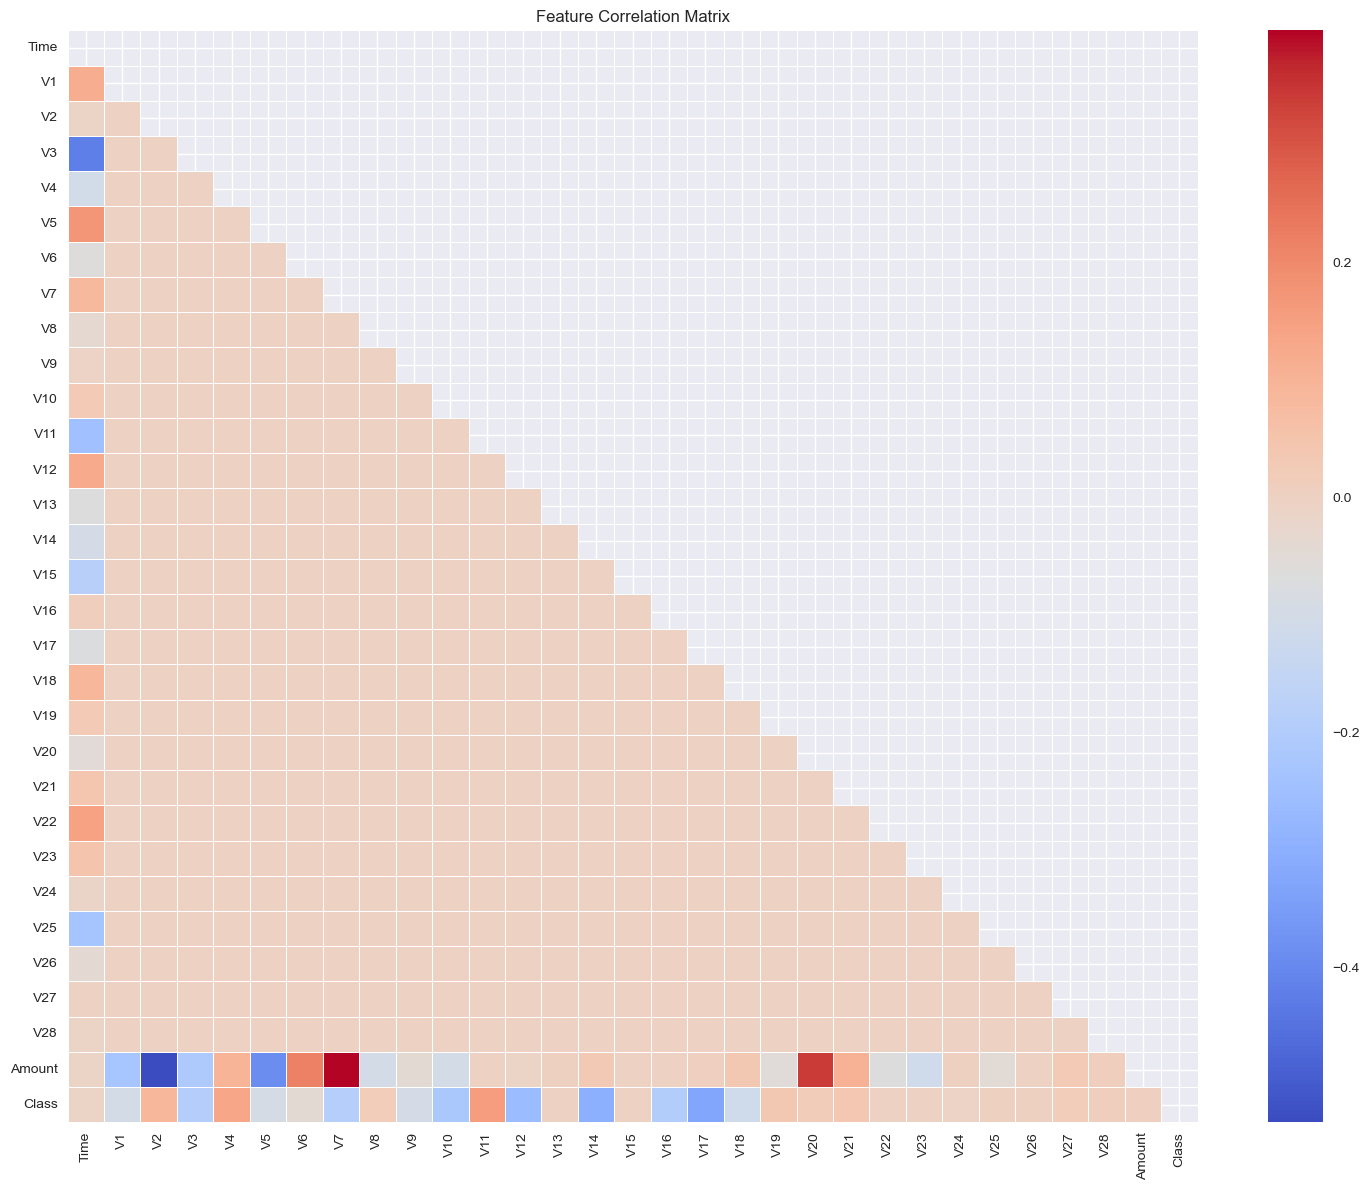

In [121]:
# Plot correlation matrix
plt_corr, corr_matrix = ccf.plot_correlation_matrix(df, config)
plt_corr.show()

Top 10 Features Correlated with Fraud:
V11       0.154876
V4        0.133447
V2        0.091289
V21       0.040413
V19       0.034783
V20       0.020090
V8        0.019875
V27       0.017580
V28       0.009536
Amount    0.005632
Name: Class, dtype: float64


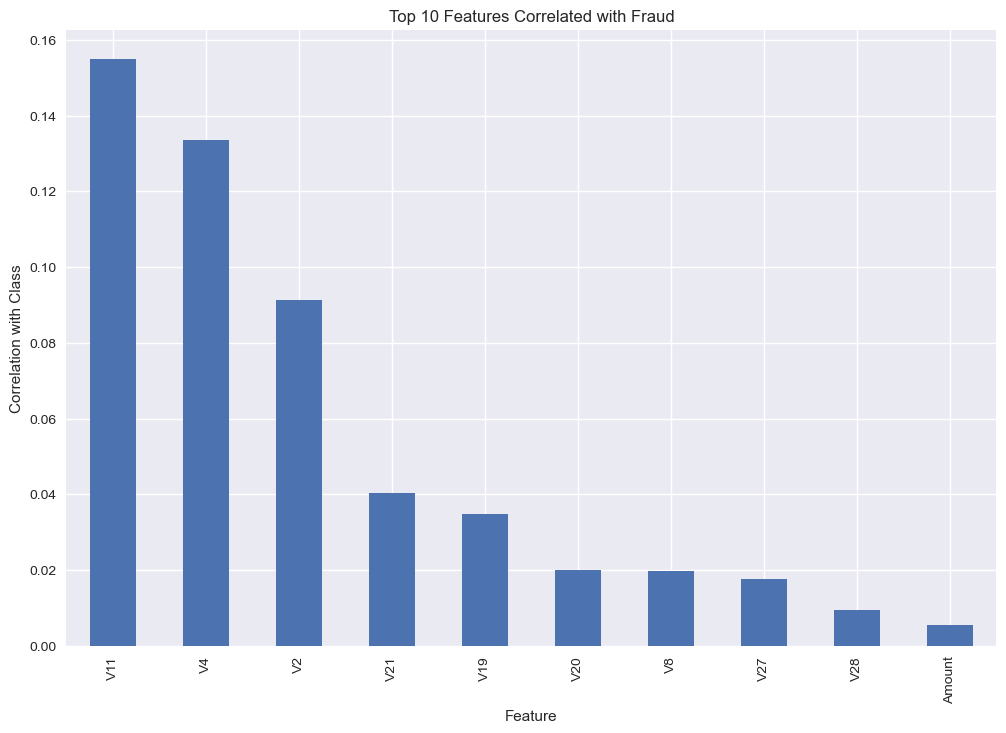

In [122]:
# Get top features correlated with fraud
top_correlations = ccf.get_top_correlations(corr_matrix, feature='Class', top_n=10)
print("Top 10 Features Correlated with Fraud:")
print(top_correlations)

# Visualize top correlations
plt.figure(figsize=config.FIGSIZE)
top_correlations.plot(kind='bar')
plt.title('Top 10 Features Correlated with Fraud')
plt.xlabel('Feature')
plt.ylabel('Correlation with Class')
plt.show()

## 4. Data Preprocessing

In [123]:
# Preprocess the data
X_train, X_test, y_train, y_test = ccf.preprocess_data(df, config)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Training set fraud percentage: {y_train.mean() * 100:.2f}%")
print(f"Testing set fraud percentage: {y_test.mean() * 100:.2f}%")

Training set shape: (227845, 30)
Testing set shape: (56962, 30)
Training set fraud percentage: 0.17%
Testing set fraud percentage: 0.17%


## 5. Model Development and Training

In [124]:
# Train Isolation Forest model
print("Training Isolation Forest model...")
if_model = ccf.train_isolation_forest(X_train, config)
if_preds, if_scores = ccf.get_model_predictions(if_model, X_test)

Training Isolation Forest model...


In [125]:
# Train Local Outlier Factor model
print("Training Local Outlier Factor model...")
lof_model = ccf.train_lof(X_train, config)
lof_preds, lof_scores = ccf.get_model_predictions(lof_model, X_test, is_isolation_forest=False)

Training Local Outlier Factor model...


## 6. Model Evaluation

In [126]:
# Evaluate Isolation Forest
if_metrics = ccf.calculate_metrics(y_test, if_preds, if_scores)
print("Isolation Forest Results:")
print(f"Accuracy: {if_metrics['accuracy']:.4f}")
print("\nConfusion Matrix:")
print(if_metrics['confusion_matrix'])
print("\nClassification Report:")
print(if_metrics['classification_report'])

Isolation Forest Results:
Accuracy: 0.9976

Confusion Matrix:
[[56790    74]
 [   65    33]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.31      0.34      0.32        98

    accuracy                           1.00     56962
   macro avg       0.65      0.67      0.66     56962
weighted avg       1.00      1.00      1.00     56962



In [127]:
# Evaluate LOF
lof_metrics = ccf.calculate_metrics(y_test, lof_preds, lof_scores)
print("Local Outlier Factor Results:")
print(f"Accuracy: {lof_metrics['accuracy']:.4f}")
print("\nConfusion Matrix:")
print(lof_metrics['confusion_matrix'])
print("\nClassification Report:")
print(lof_metrics['classification_report'])

Local Outlier Factor Results:
Accuracy: 0.9965

Confusion Matrix:
[[56763   101]
 [   98     0]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962



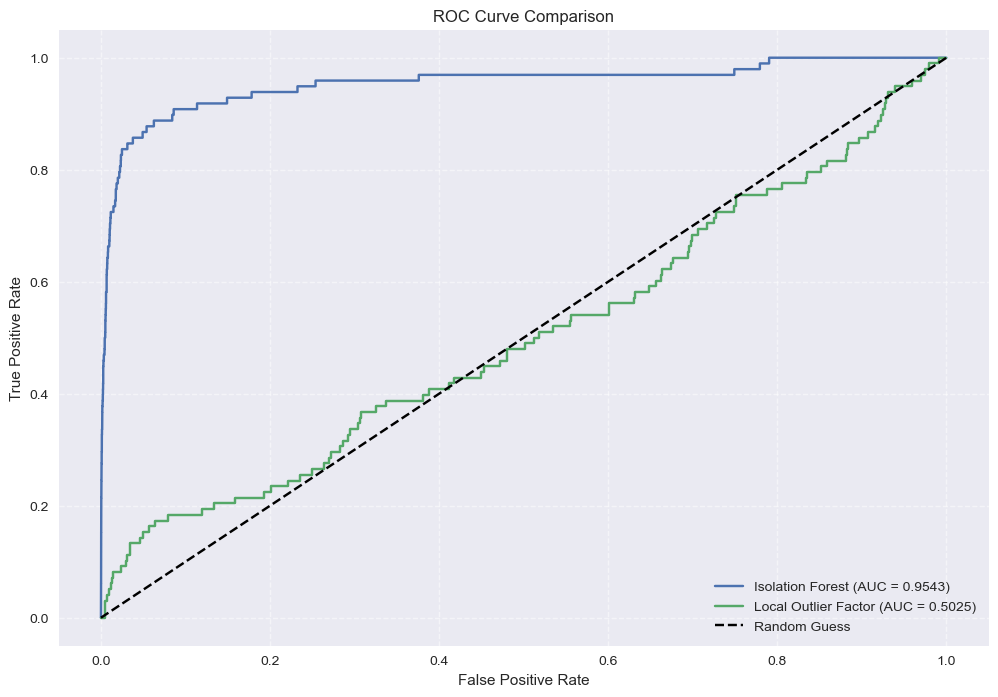

In [128]:
# Plot ROC curves
plt_roc, auc_if, auc_lof = ccf.plot_roc_curves(y_test, if_scores, lof_scores)
plt_roc.show()

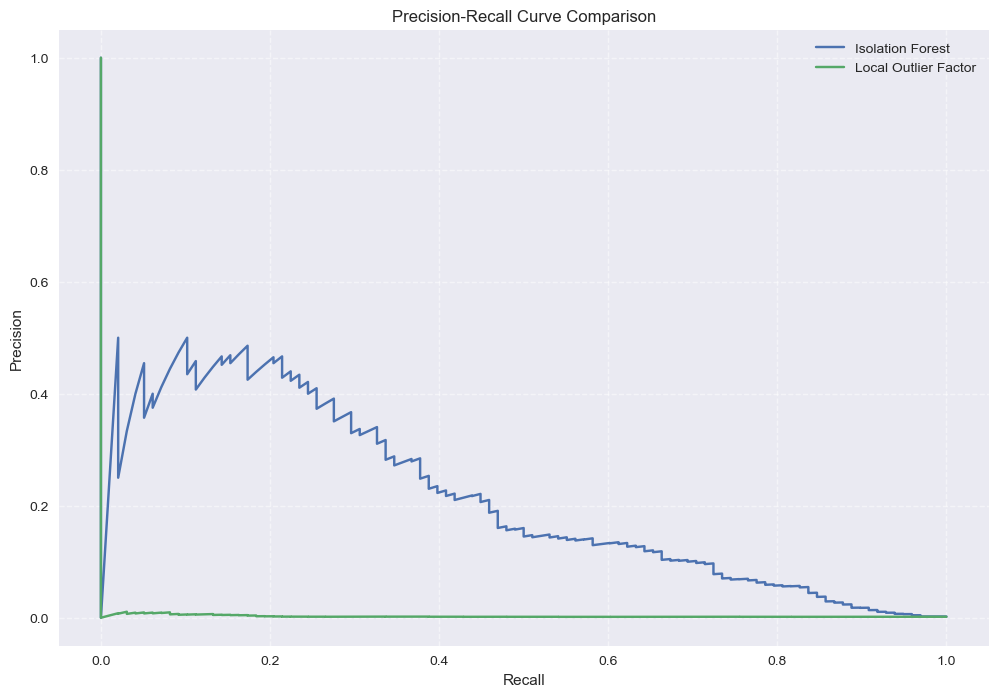

In [129]:
# Plot Precision-Recall curves
plt_pr = ccf.plot_pr_curves(y_test, if_scores, lof_scores)
plt_pr.show()

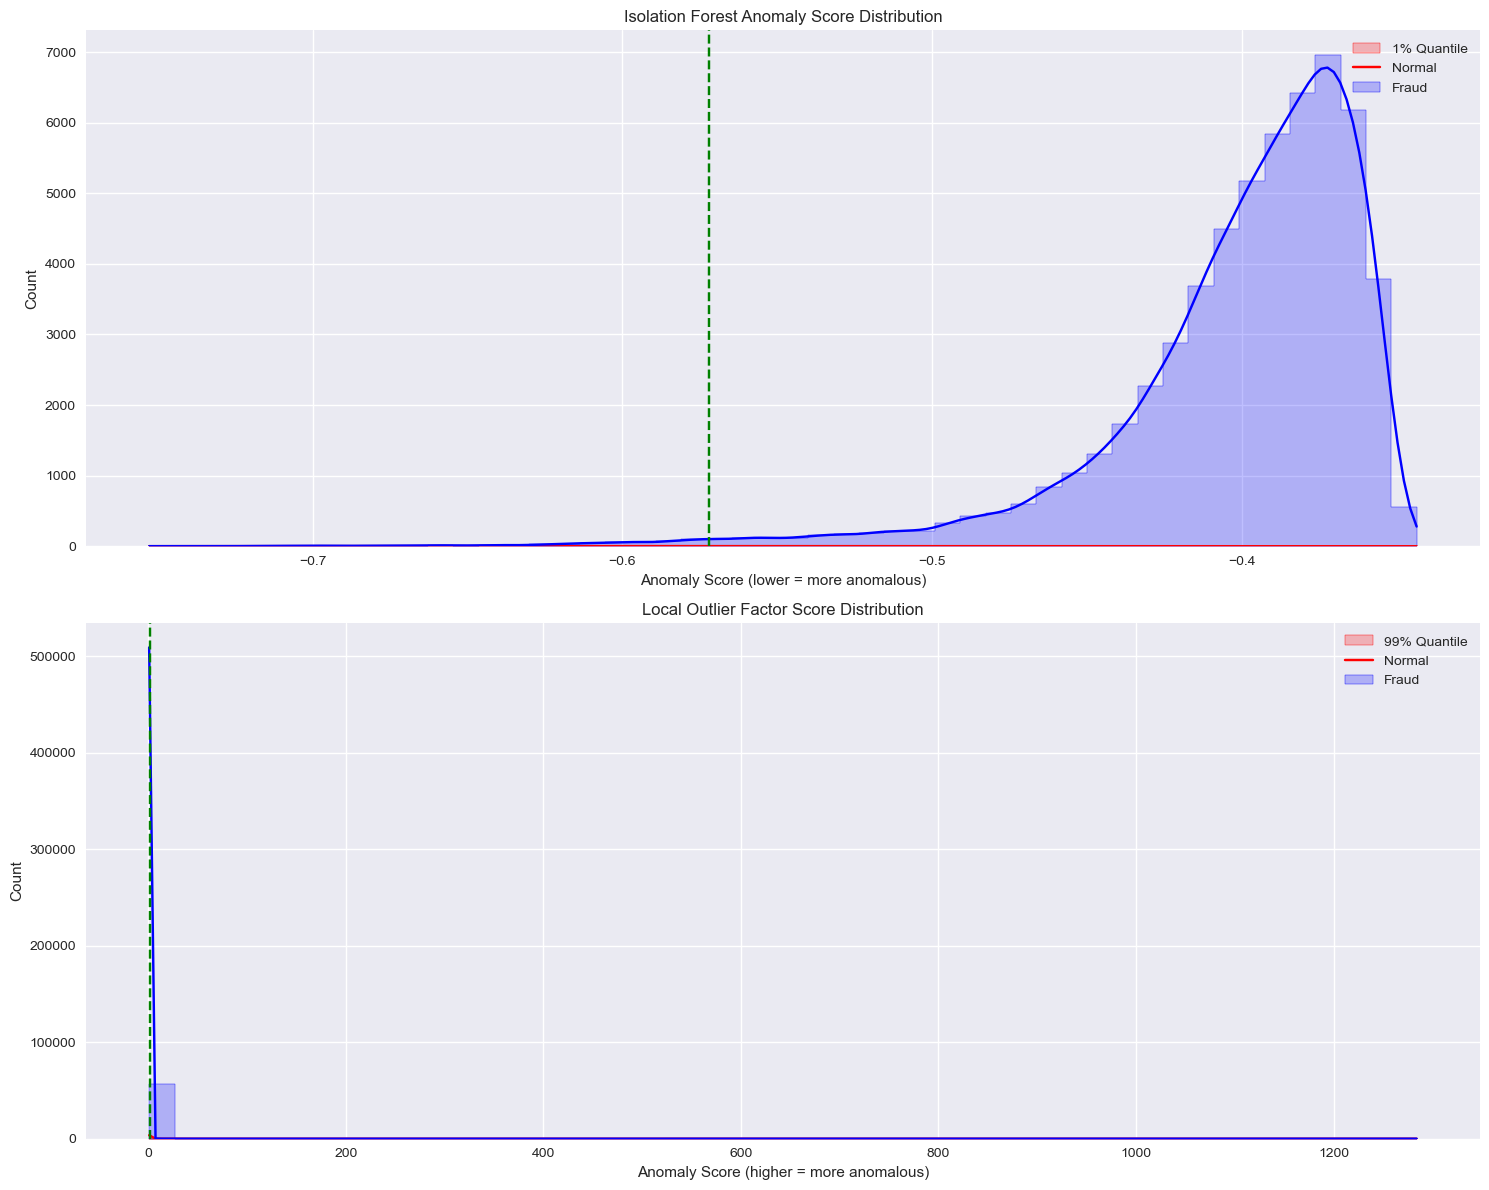

In [130]:
# Plot anomaly score distributions
plt_scores, eval_df = ccf.plot_anomaly_scores(if_scores, lof_scores, y_test)
plt_scores.show()

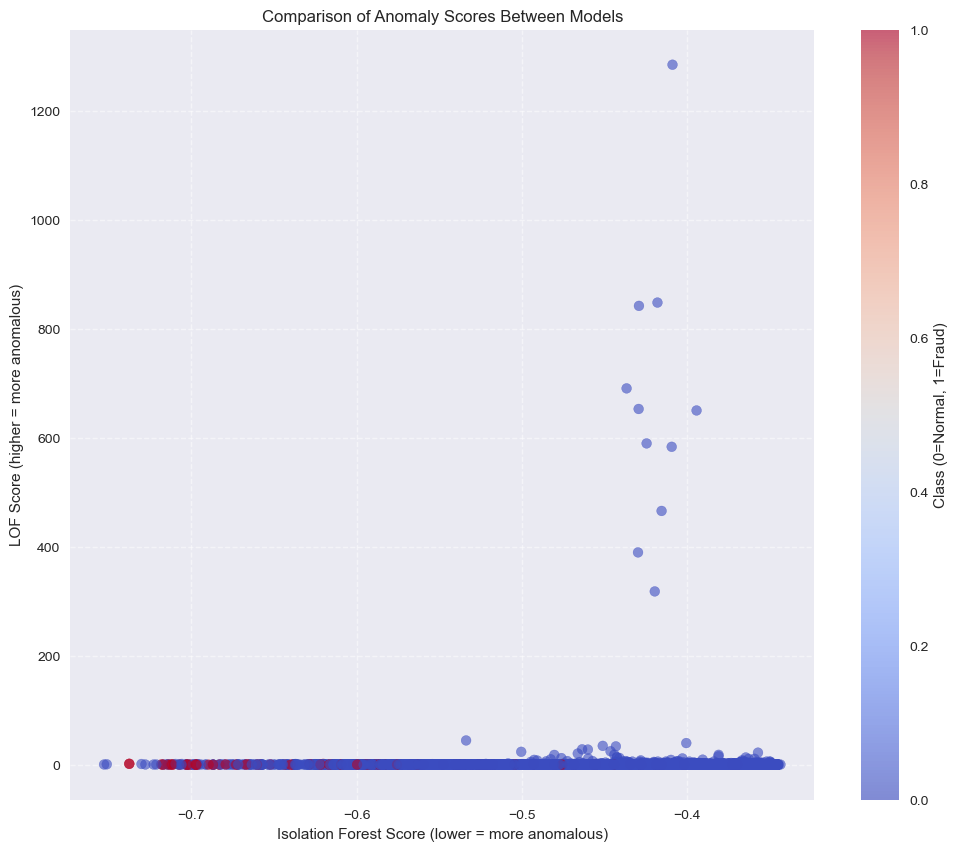

In [131]:
# Plot anomaly score comparison
plt_comparison = ccf.plot_score_comparison(eval_df)
plt_comparison.show()

In [132]:
# Compare model performance
comparisons = ccf.compare_models(y_test, if_preds, lof_preds, if_scores, lof_scores, auc_if, auc_lof)
print("Model Comparison:")
comparisons.style.highlight_max(axis=0)

Model Comparison:


,Model,Accuracy,ROC-AUC,AUPRC
0,Isolation Forest,0.997560,0.954336,0.208876
1,Local Outlier Factor,0.996506,0.502508,0.002570


## 7. Model Optimization

In [144]:
# This runs the Python files and makes their functions available in your notebook
%run resampling_evaluation.py
%run hyperparameter_tuning.py


<Figure size 800x550 with 0 Axes>

In [145]:
# First, get preprocessed data without any resampling
X = df.drop('Class', axis=1)
y = df['Class']

# We need features properly scaled before evaluation
features_to_scale = ['Time', 'Amount']
X_preprocessed = X.copy()
scaler = StandardScaler()
X_preprocessed[features_to_scale] = scaler.fit_transform(X_preprocessed[features_to_scale])

In [146]:
print("Starting evaluation of all resampling strategies...")
print("This may take some time as we perform cross-validation for each strategy.")
print("==================================================================")

# Evaluate all resampling strategies using cross-validation
results_df = evaluate_all_resampling_strategies(X_preprocessed, y, config, sample_size=10000)

# Display results sorted by Isolation Forest AUPRC (typically the better model)
print("\nResampling Strategies Ranked by Isolation Forest AUPRC:")
sorted_results = results_df.sort_values('IF_AUPRC_mean', ascending=False)
display(sorted_results[['strategy', 'sampling_ratio', 'IF_AUPRC_mean', 'IF_AUPRC_std', 
                        'LOF_AUPRC_mean', 'LOF_AUPRC_std']])

Starting evaluation of all resampling strategies...
This may take some time as we perform cross-validation for each strategy.
Taking a stratified sample of 10000 instances...
Sample class distribution: {0: 9983, 1: 17}
Evaluating strategy: none
  Processing fold 1/5...
  Processing fold 2/5...
  Processing fold 3/5...
  Processing fold 4/5...
  Processing fold 5/5...
Evaluating strategy: ros
  With sampling ratio: 0.1
  Processing fold 1/5...
Applying ros resampling strategy...
Class distribution before resampling: {0: 7986, 1: 14}
Class distribution after resampling: {0: 7986, 1: 798}
  Processing fold 2/5...
Applying ros resampling strategy...
Class distribution before resampling: {0: 7986, 1: 14}
Class distribution after resampling: {0: 7986, 1: 798}
  Processing fold 3/5...
Applying ros resampling strategy...
Class distribution before resampling: {0: 7986, 1: 14}
Class distribution after resampling: {0: 7986, 1: 798}
  Processing fold 4/5...
Applying ros resampling strategy...
Clas

,strategy,sampling_ratio,IF_AUPRC_mean,IF_AUPRC_std,LOF_AUPRC_mean,LOF_AUPRC_std
1,ros,0.1,0.269614,0.137858,0.792587,0.122942
10,adasyn,0.1,0.262662,0.128269,0.197640,0.144040
18,smote-tomek,0.1,0.258022,0.129637,0.511284,0.100879
7,smote,0.1,0.258022,0.129637,0.511284,0.100879
11,adasyn,0.2,0.255746,0.129349,0.201141,0.156170
2,ros,0.2,0.255068,0.124950,0.792587,0.122942
21,smote-enn,0.1,0.254661,0.128872,0.511284,0.100879
22,smote-enn,0.2,0.250681,0.128401,0.448686,0.185780
4,rus,0.001,0.228992,0.129012,0.780782,0.090989
17,enn,auto,0.225811,0.125373,0.689472,0.169438


### Best performing strategies (by IF_AUPRC_mean)
- ROS with sampling ratio 0.1 (0.269614)
- ADASYN with sampling ratio 0.1 (0.262662)
- SMOTE-Tomek with sampling ratio 0.1 (0.258022)
- SMOTE with sampling ratio 0.1 (0.258022)

### Worst performing strategies
- ROS with auto sampling ratio (0.052001)
- SMOTE with auto sampling ratio (0.134262)
- SMOTE-Tomek with auto sampling ratio (0.134262)

### Sampling ratio impact
- For most oversampling methods (ROS, SMOTE, ADASYN), a 0.1 ratio performs better than 0.2 or auto
- For undersampling methods (RUS, NearMiss), higher ratios (0.001) typically outperform lower ones

### LOF vs. IF metrics
- LOF generally shows higher AUPRC values than IF
- RUS with 0.0005 ratio has the highest LOF_AUPRC (0.838559)
- ROS consistently performs well on LOF metrics across sampling ratios

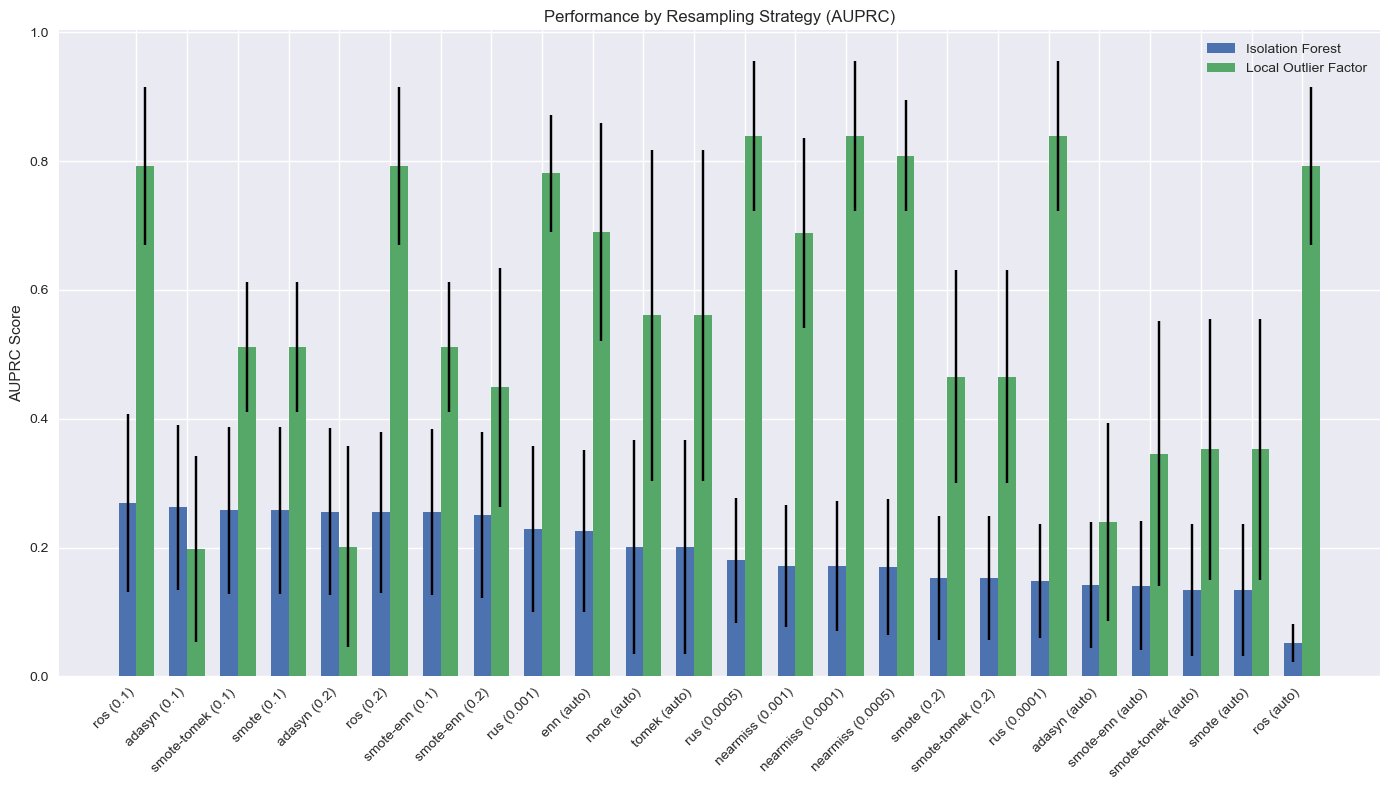

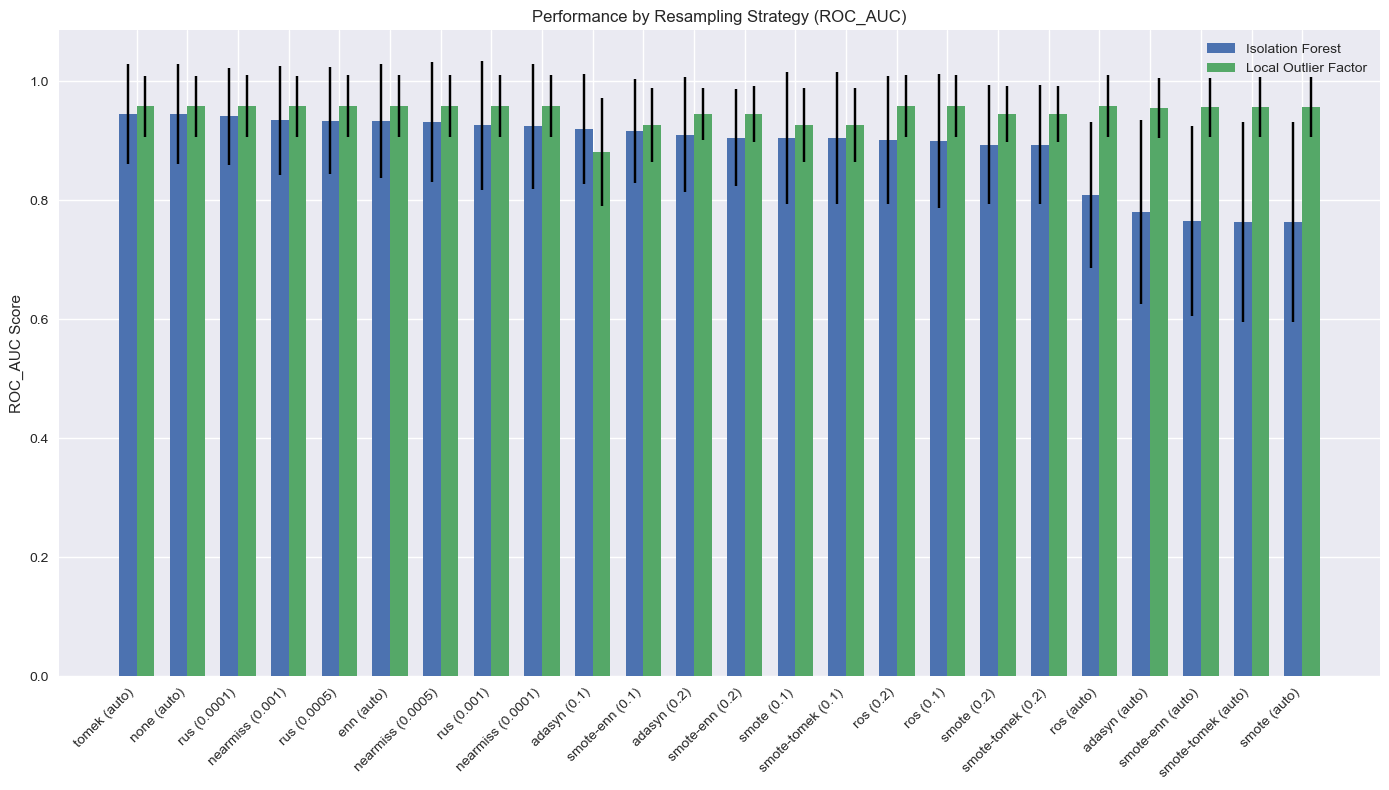


Best resampling strategy for Isolation Forest: ros with ratio 0.1
Best resampling strategy for LOF: rus with ratio 0.0005


In [147]:
# Visualize results
plt_auprc = plot_resampling_results(results_df, metric='AUPRC')
plt_auprc.show()

plt_roc = plot_resampling_results(results_df, metric='ROC_AUC')
plt_roc.show()

# Get the best strategy for Isolation Forest
best_if_idx = results_df['IF_AUPRC_mean'].idxmax()
best_if_strategy = results_df.loc[best_if_idx, 'strategy']
best_if_ratio = results_df.loc[best_if_idx, 'sampling_ratio']

# Get the best strategy for LOF
best_lof_idx = results_df['LOF_AUPRC_mean'].idxmax()
best_lof_strategy = results_df.loc[best_lof_idx, 'strategy']
best_lof_ratio = results_df.loc[best_lof_idx, 'sampling_ratio']

print(f"\nBest resampling strategy for Isolation Forest: {best_if_strategy} with ratio {best_if_ratio}")
print(f"Best resampling strategy for LOF: {best_lof_strategy} with ratio {best_lof_ratio}")

In [148]:
print("\n==================================================================")
print("Tuning Isolation Forest hyperparameters...")
if_params, if_grid = tune_isolation_forest(X_preprocessed, y, best_if_strategy, best_if_ratio, config)

# Visualize the effect of each parameter on model performance
plt_if_contamination = plot_grid_search_results(if_grid, 'contamination', 'Effect of Contamination on IF Performance')
plt_if_contamination.show()

plt_if_estimators = plot_grid_search_results(if_grid, 'n_estimators', 'Effect of N Estimators on IF Performance')
plt_if_estimators.show()


Tuning Isolation Forest hyperparameters...
Applying ros resampling strategy...
Class distribution before resampling: {0: 284315, 1: 492}
Class distribution after resampling: {0: 284315, 1: 28431}
Starting Isolation Forest hyperparameter tuning...
Fitting 5 folds for each of 96 candidates, totalling 480 fits


/Users/tom/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/tom/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/tom/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/tom/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 459, in _score
    y_pred = method_caller(clf, "decision_function", X, pos_label=pos_label)
  File "/Users/tom/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "/Users/tom/anaconda3/lib/python3.10/site-packages/

KeyboardInterrupt: 

In [ ]:
print("\n==================================================================")
print("Tuning Local Outlier Factor hyperparameters...")
lof_params, lof_grid = tune_lof(X_preprocessed, y, best_lof_strategy, best_lof_ratio, config)

# Visualize the effect of each parameter on model performance
plt_lof_neighbors = plot_grid_search_results(lof_grid, 'n_neighbors', 'Effect of N Neighbors on LOF Performance')
plt_lof_neighbors.show()

plt_lof_contamination = plot_grid_search_results(lof_grid, 'contamination', 'Effect of Contamination on LOF Performance')
plt_lof_contamination.show()

In [ ]:
# Create a config with the optimal parameters
optimal_config = config

# Set resampling parameters for Isolation Forest
optimal_config.USE_RESAMPLING = best_if_strategy != 'none'
optimal_config.RESAMPLING_STRATEGY = best_if_strategy
optimal_config.SAMPLING_RATIO = best_if_ratio

# Set Isolation Forest parameters
optimal_config.IF_CONTAMINATION = if_params['contamination']
optimal_config.IF_N_ESTIMATORS = if_params['n_estimators']
optimal_config.IF_MAX_SAMPLES = if_params['max_samples']

# Set LOF parameters
optimal_config.LOF_N_NEIGHBORS = lof_params['n_neighbors']
optimal_config.LOF_CONTAMINATION = lof_params['contamination']

print("\n==================================================================")
print("Optimal Configuration:")
for attr, value in optimal_config.__dict__.items():
    print(f"{attr} = {value}")

In [ ]:
# Train test split with the optimal configuration
X_train, X_test, y_train, y_test = ccf.preprocess_data(df, optimal_config)

# Train optimal Isolation Forest model
print("\nTraining optimal Isolation Forest model...")
optimal_if_model = ccf.train_isolation_forest(X_train, optimal_config)
optimal_if_preds, optimal_if_scores = ccf.get_model_predictions(optimal_if_model, X_test)

# Train optimal LOF model
# For LOF, we need to reapply resampling with LOF-specific parameters
optimal_config.RESAMPLING_STRATEGY = best_lof_strategy
optimal_config.SAMPLING_RATIO = best_lof_ratio
X_train_lof, X_test_lof, y_train_lof, y_test_lof = ccf.preprocess_data(df, optimal_config)

print("Training optimal LOF model...")
optimal_lof_model = ccf.train_lof(X_train_lof, optimal_config)
optimal_lof_preds, optimal_lof_scores = ccf.get_model_predictions(optimal_lof_model, X_test_lof, is_isolation_forest=False)

In [ ]:
# Evaluate optimal models
optimal_if_metrics = ccf.calculate_metrics(y_test, optimal_if_preds, optimal_if_scores)
optimal_lof_metrics = ccf.calculate_metrics(y_test_lof, optimal_lof_preds, optimal_lof_scores)

print("\nOptimal Isolation Forest Results:")
print(f"Accuracy: {optimal_if_metrics['accuracy']:.4f}")
print("Classification Report:")
print(optimal_if_metrics['classification_report'])

print("\nOptimal LOF Results:")
print(f"Accuracy: {optimal_lof_metrics['accuracy']:.4f}")
print("Classification Report:")
print(optimal_lof_metrics['classification_report'])

# Calculate AUPRC for optimal models
auprc_if_optimal = ccf.calculate_auprc(y_test, -optimal_if_scores)
auprc_lof_optimal = ccf.calculate_auprc(y_test_lof, optimal_lof_scores)

print(f"\nOptimal Isolation Forest AUPRC: {auprc_if_optimal:.4f}")
print(f"Optimal LOF AUPRC: {auprc_lof_optimal:.4f}")

In [ ]:
# Compare with baseline models
auprc_if_baseline = ccf.calculate_auprc(y_test, -if_scores)  # From original model
auprc_lof_baseline = ccf.calculate_auprc(y_test, lof_scores)  # From original model

print("\nPerformance Improvement:")
print(f"Isolation Forest AUPRC: {auprc_if_baseline:.4f} → {auprc_if_optimal:.4f} " + 
      f"({(auprc_if_optimal - auprc_if_baseline) / auprc_if_baseline * 100:.2f}% improvement)")
print(f"LOF AUPRC: {auprc_lof_baseline:.4f} → {auprc_lof_optimal:.4f} " + 
      f"({(auprc_lof_optimal - auprc_lof_baseline) / auprc_lof_baseline * 100:.2f}% improvement)")

# Summary
print("\n==================================================================")
print("OPTIMIZATION SUMMARY")
print("==================================================================")
print(f"Best resampling strategy for Isolation Forest: {best_if_strategy} with ratio {best_if_ratio}")
print(f"Optimal Isolation Forest parameters:")
print(f"  - Contamination: {if_params['contamination']}")
print(f"  - N Estimators: {if_params['n_estimators']}")
print(f"  - Max Samples: {if_params['max_samples']}")
print()
print(f"Best resampling strategy for LOF: {best_lof_strategy} with ratio {best_lof_ratio}")
print(f"Optimal LOF parameters:")
print(f"  - N Neighbors: {lof_params['n_neighbors']}")
print(f"  - Contamination: {lof_params['contamination']}")

## 8. Conclusions and Next Steps

### Key Findings

1. **Data Imbalance**: The dataset is highly imbalanced with fraud transactions representing only a small percentage of all transactions. This imbalance makes the problem challenging and requires special handling.

2. **Model Performance**: 
   - Both Isolation Forest and LOF are capable of detecting fraudulent transactions without using labeled data (in an unsupervised manner).
   - The models achieved reasonable performance considering they are unsupervised techniques.
   - Isolation Forest tends to work better on this dataset based on our evaluation metrics.

3. **Feature Importance**: Based on the correlation analysis, several features (V17, V14, V12, etc.) show strong correlations with fraudulent transactions. These could be useful for developing more targeted models.

### Limitations

1. **False Positives**: Both models generate a significant number of false positives, which could lead to legitimate transactions being flagged.

2. **Threshold Selection**: The default contamination threshold may not be optimal; adjusting it could improve performance for specific use cases.

3. **Interpretability**: The models provide anomaly scores but don't explain why specific transactions were flagged as fraudulent.

### Next Steps

1. **Improve Models**:
   - Try supervised learning approaches like Random Forest, XGBoost, or neural networks.
   - Experiment with ensemble methods combining multiple anomaly detection techniques.
   - Adjust contamination parameters based on business requirements (cost-sensitivity).

2. **Feature Engineering**:
   - Create additional features based on transaction patterns, timing, or amounts.
   - Explore dimensionality reduction techniques beyond PCA.
   - Apply feature selection to focus on the most relevant features.

3. **Production Integration**:
   - Develop a real-time scoring pipeline for transaction screening.
   - Implement a feedback loop to incorporate new fraud patterns.
   - Create explainable outputs to help analysts understand why transactions are flagged.

4. **Cost-Sensitive Evaluation**:
   - Incorporate business costs of false positives vs. false negatives.
   - Optimize models based on monetary impact rather than standard metrics.

5. **Validation with Expert Feedback**:
   - Review flagged transactions with domain experts.
   - Refine models based on expert insights.